# Human Activity Recognition using Clustering


**Integrantes:**
- Lucas Carranza
- Guillermo Sánchez
- David Herencia
- José Osnayo

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

import os
import glob

###### Funciones de apoyo:

In [58]:
def to_csv_labels(labels, output_csv, test_ids, test_df):
    kmeans_m_series = pd.Series([int(i) for i in labels], name='label')
    df_kmeans_m = pd.concat([test_ids, kmeans_m_series], axis=1)
    print(len(df_kmeans_m))
    if len(df_kmeans_m) < 805:
        # Find the missing youtube_id
        set1 = set(test_df['youtube_id'])
        set2 = set(df_kmeans_m['youtube_id'])
        missing_youtube_id = list(set1 - set2)
        new_row = pd.DataFrame({'youtube_id': missing_youtube_id, 'label': 0})

        # Append the new row to df
        df_kmeans_m = pd.concat([df_kmeans_m, new_row], ignore_index=True)
        print(len(df_kmeans_m))
    df_kmeans_m.head()

    df_kmeans_m.to_csv(output_csv, index=False)
    print(f"CSV con predicciones guardado en: {output_csv}")

def expand_scores(df, score_name):
    df_expanded = df.copy()
    df_expanded[[f'{score_name}_train', f'{score_name}_val', f'{score_name}_test']] = pd.DataFrame(df[score_name].tolist(), index=df.index)
    return df_expanded

def plot_metrics_grid(df, metrics, k):
    # Filter hyperparameters to plot
    first_row = df.iloc[0]
    middle_row = df.iloc[len(df) // 2]
    last_row = df.iloc[-1]

    # Create a new DataFrame with these rows
    df = pd.DataFrame([first_row, middle_row, last_row])

    # Expand the DataFrame for each metric
    for metric in metrics:
        df = expand_scores(df, metric)

    # Create a new column for hyperparameter combinations
    df['combination'] = df.index.map(str)

    # Set up the plot grid
    num_metrics = len(metrics)
    fig, axes = plt.subplots(1, num_metrics, figsize=(4 * num_metrics, 3), sharey=True)

    for i, metric in enumerate(metrics):
        ax = axes[i] if num_metrics > 1 else axes
        width = 0.1  # Width bars
        x = range(len(df['combination']))
        ax.bar(x, df[f'{metric}_train'], width=width, label=f'{metric}_train', align='center')
        ax.bar([p + width for p in x], df[f'{metric}_val'], width=width, label=f'{metric}_val', align='center')
        ax.bar([p + width*2 for p in x], df[f'{metric}_test'], width=width, label=f'{metric}_test', align='center')

        ax.set_title(f'{metric.capitalize()} Scores')
        ax.set_xlabel('Hyperparameter Combination')
        ax.set_ylabel('Score')
        ax.set_xticks([p + width for p in x])
        ax.set_xticklabels(df['combination'], rotation=90)
        ax.legend(prop={'size': 'xx-small'})

    plt.tight_layout()
    plt.show()

## Dataset Analysis

### Lectura de los csv
Leemos los archivos .csv que contienen el id único de cada video, y la clase correspondiente para el entrenamiento y validación.

In [4]:
train_path = "data/train_subset_10.csv"
val_path = "data/val_subset_10.csv"
test_path = "data/test_subset_10.csv"

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)
train_df.head()

,youtube_id,label
0,zeIkGEHK46I,riding camel
1,-Fwy8NwefTk,shot put
2,sDD0p8h88rI,dying hair
3,09AinCnKAE8,riding camel
4,qyTDZajMSqQ,baking cookies


### Análisis de Frecuencias

Analizamos las frecuencias de las apariciones de las clases en la data de entrenamiento para saber si requerimos de consideraciones especiales por desbalanceo.

Observamos que la data de validación se encuentra bien balanceada, mientras que la data de entrenamiento no lo está. El ratio de frecuencias entre la clase con más apariciones 'dying hair' y la clase con menos apariciones 'spraying' es de 2.75 a 1 aproximadamente.

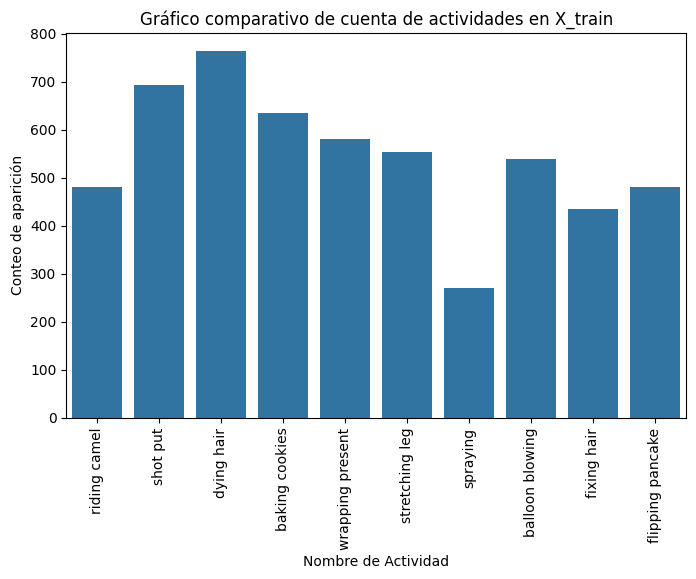

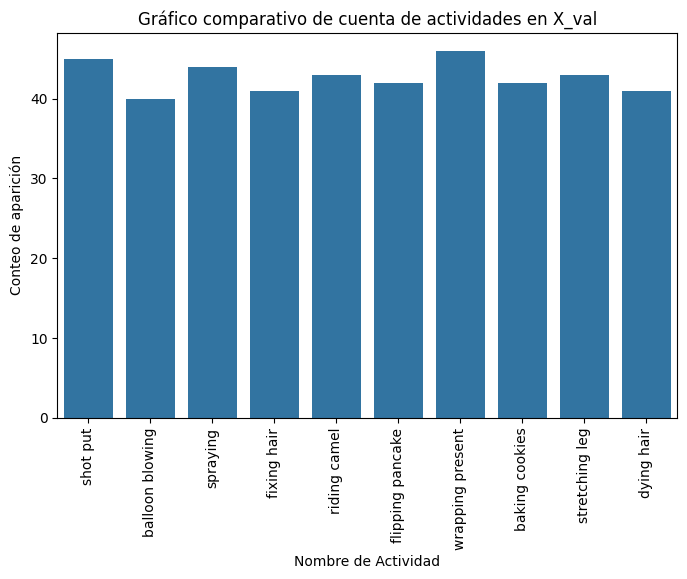

In [5]:
plt.figure(figsize=(8,5))
sns.countplot(x='label', data=train_df)
plt.xticks(rotation='vertical')
plt.title('Gráfico comparativo de cuenta de actividades en X_train')
plt.xlabel('Nombre de Actividad')
plt.ylabel('Conteo de aparición')

plt.figure(figsize=(8,5))
sns.countplot(x='label', data=val_df)
plt.xticks(rotation='vertical')
plt.title('Gráfico comparativo de cuenta de actividades en X_val')
plt.xlabel('Nombre de Actividad')
plt.ylabel('Conteo de aparición')


plt.show()

### Extracción de Features

Utilizamos la librería video_features para extraer el vector característico de cada video, utilizando el modelo R(2+1)D que está especializado en el reconocimiento de actividades.
Para esto necesitamos generar un archivo de texto que contenga las rutas de archivo a cada video a procesar.

In [6]:
# # Script para recortar los nombres de cada video a unicamente el id
# for directory in ['./data/train_subset', './data/test_subset', './data/val_subset']:
#     changed_count = 0
#     for filename in os.listdir(directory):
#         if filename.endswith(".mp4") and '_' in filename:
#             youtube_id = filename.split('_')[0]
#             new_filename = f"{youtube_id}.mp4"
#             old_file = os.path.join(directory, filename)
#             new_file = os.path.join(directory, new_filename)

#             ''' DESCOMENTAR PARA EJECUTAR CAMBIOS '''
#             # os.rename(old_file, new_file)
#             # changed_count += 1

#     print(f"Renaming process for {directory} completed. Updated {changed_count} file names")

In [7]:
# # Script para guardar las rutas de los videos en un archivo .txt
# paths = []
# directory = '/home/lucas/projects/jupyter_nb/HAClustering/data/'
# # for youtube_id in train_df['youtube_id']:
#     # paths.append(os.path.join(directory, f"train_subset/{youtube_id}.mp4"))
# for youtube_id in val_df['youtube_id']:
#     paths.append(os.path.join(directory, f"val_subset/{youtube_id}.mp4"))
# for youtube_id in test_df['youtube_id']:
#     paths.append(os.path.join(directory, f"test_subset/{youtube_id}.mp4"))

# # write to .txt
# output_file = './data/paths.txt'
# with open(output_file, 'w') as f:
#     for path in paths:
#         ''' DESCOMENTAR PARA EJECUTAR CAMBIOS '''
#         f.write(f"{path}\n")

# print("Finished writing video paths")

Una vez que ejecutamos el código de la librería video_features y procesamos cada video pot el modelo R(2+1)D, obtenemos una serie de vectores característicos almacenados en un archivo de numpy (.npy), donde cada video tiene su archivo correspondiente. Cada vector característico tiene el formato `{youtube_id}_r21d.npy`.

Leemos y procesamos cada vector característico para almacenarlo en un nuevo dataframe, y eliminamos aquellos vectores que hayan 

In [8]:
feature_path = './r2plus1d_ig65m'

def consolidate_features(path, df, return_labels=True):
    features = []
    labels = []
    ids = []
    invalid = 0
    for video in glob.glob(os.path.join(path, '*.npy')):
        youtube_id = os.path.basename(video).split('_')[0]
        current = np.load(video)
        # Skip videos not in df
        if youtube_id not in df['youtube_id'].values:
            continue
        # skip invalid videos
        if current.size == 0:
            invalid += 1
            continue
        features.append(np.mean(current, axis = 0))
        ids.append(youtube_id)
        if return_labels:
            labels.append(df[df['youtube_id'] == youtube_id]['label'].values[0])
    print("# Vectores invalidos: ", invalid)
    features = pd.DataFrame(np.vstack(features))
    ids = pd.DataFrame({'youtube_id': ids})
    
    if return_labels:
        labels = pd.DataFrame(np.vstack(labels))
        return features, labels, ids
    else:
        return features, ids

In [9]:
X_train, Y_train, train_ids = consolidate_features(feature_path, train_df)
X_val, Y_val, val_ids = consolidate_features(feature_path, val_df)
X_test, test_ids = consolidate_features(feature_path, test_df, return_labels=False)
print("Finished consolidating feature vectors")
X_train.head()

# Vectores invalidos:  6
# Vectores invalidos:  0
# Vectores invalidos:  1
Finished consolidating feature vectors


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,2.043049,0.775911,1.092079,0.132731,1.763130,2.669859,1.255954,0.148139,1.224447,1.407301,...,0.464645,2.989628,0.391416,0.116563,0.131220,0.405040,1.120665,0.369314,1.099866,0.675465
1,0.095979,1.073375,0.483646,1.290228,0.149837,0.289791,0.603562,0.028958,0.439656,1.346853,...,1.815488,0.373870,0.587250,0.329209,1.096944,0.824835,1.667245,0.612600,0.718933,0.895765
2,1.143614,0.223483,0.790342,0.477821,0.931772,0.365202,0.263473,0.940660,0.542360,0.507267,...,1.369049,0.185284,0.893333,0.213472,0.377429,0.757547,0.824203,0.079453,0.831170,0.168950
3,0.684313,1.345115,1.549848,1.661144,0.165922,0.511371,2.476032,0.500792,0.879074,0.164017,...,0.344035,0.001565,1.665342,0.060357,0.047794,0.299733,0.516325,1.100517,0.242082,0.623901
4,2.108435,0.669570,0.072180,0.953708,1.778666,1.974557,0.287178,0.237630,0.744035,1.320337,...,1.320232,1.514168,0.425998,1.546256,0.228560,0.785142,1.175889,0.699259,1.492890,0.206487


In [10]:
print("feature vectors  : ", len(X_train) + len(X_val) + len(X_test))
print("original csv len : ", len(train_df) + len(val_df) + len(test_df))
missing_train = len(train_df) - len(X_train)
missing_val = len(val_df) - len(X_val)
missing_test = len(test_df) - len(X_test)
print("missing_train: ", missing_train)
print("missing_val: ", missing_val)
print("missing_test: ", missing_test)

feature vectors  :  6639
original csv len :  6664
missing_train:  23
missing_val:  1
missing_test:  1


## Reducción de Dimensionalidad

### Normalización

Probamos con distintos algoritmos de normalización de la libería scikit-learn para comprobar el impacto de estos en la calidad de los clusters generados al reducir la dimensionalidad.

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

# scaler = StandardScaler()
scaler = PowerTransformer(method='yeo-johnson')
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [12]:
from sklearn.metrics import silhouette_score, adjusted_rand_score
train_numeric_labels, _ = pd.factorize(Y_train[0])
val_numeric_labels, _ = pd.factorize(Y_val[0])

### Sin Reducción:

Probamos la calidad de los clusters antes de la reducción de dimensionalidad, como benchmark para medir la pérdida de calidad al aplicarle los demás algoritmos.

In [13]:
print(f"Number of features: {X_train_scaled.shape[1]}")

silhouette_train = silhouette_score(X_train_scaled, train_numeric_labels)
silhouette_val = silhouette_score(X_val_scaled, val_numeric_labels)

print(f"Silhouette Score for Training Data: {silhouette_train}")
print(f"Silhouette Score for Validation Data: {silhouette_val}")

Number of features: 512
Silhouette Score for Training Data: 0.37410259042516125
Silhouette Score for Validation Data: 0.3014258174339


### PCA:
Probamos con el algoritmo de PCA para reducir la dimensionalidad de los vectores característicos, con el fin de hallar el número de componentes necesarios para explicar el 95% de la varianza.

Comprobamos como se ven los clusters tras realizar la reducción de Dimensionalidad, y obtenemos las puntuaciones de sus métricas.

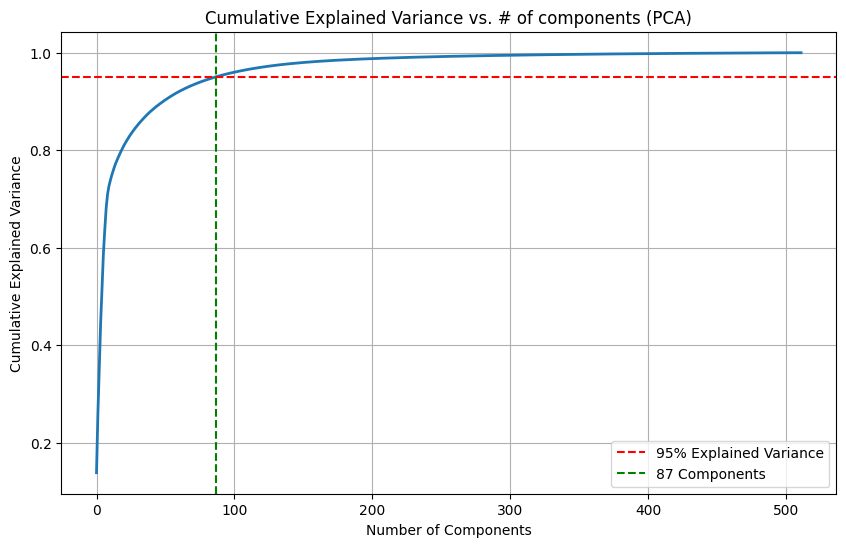

N_componentes:  87


In [14]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)
k_pca = np.argmax(cumsum >= 0.95)

plt.figure(figsize=(10, 6))
plt.plot(cumsum, linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.axvline(x=k_pca, color='g', linestyle='--', label=f'{k_pca} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. # of components (PCA)')
plt.legend()
plt.grid(True)
plt.show()

print("N_componentes: ",k_pca)

In [15]:
pca2 = PCA(k_pca)
X_train_pca = pca2.fit_transform(X_train_scaled)
X_val_pca = pca2.transform(X_val_scaled)
X_test_pca = pca2.transform(X_test_scaled)

Number of features: 87
Silhouette Score for Training Data: 0.4018457475456099
Silhouette Score for Validation Data: 0.32780517719291885


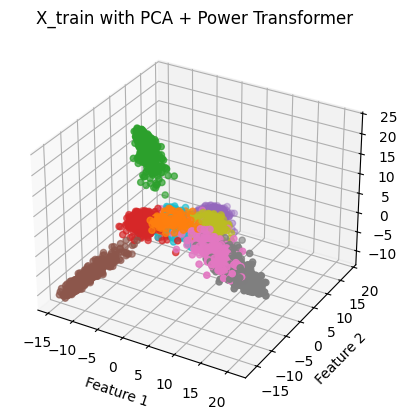

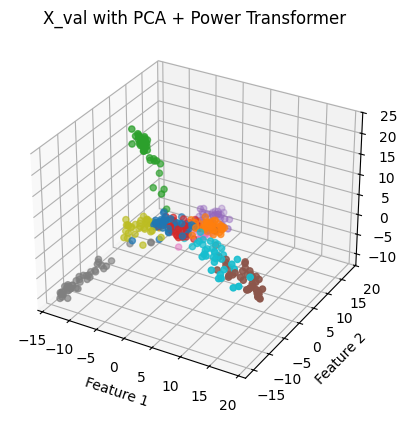

In [16]:
print(f"Number of features: {X_train_pca.shape[1]}")

silhouette_train = silhouette_score(X_train_pca, train_numeric_labels)
silhouette_val = silhouette_score(X_val_pca, val_numeric_labels)

print(f"Silhouette Score for Training Data: {silhouette_train}")
print(f"Silhouette Score for Validation Data: {silhouette_val}")

# Plot for X_train
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=train_numeric_labels, cmap='tab10')
ax.set_title("X_train with PCA + Power Transformer")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
plt.show()

# Plot for X_val
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_val_pca[:, 0], X_val_pca[:, 1], X_val_pca[:, 2], c=val_numeric_labels, cmap='tab10')
ax.set_title("X_val with PCA + Power Transformer")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
plt.show()

### UMAP:

Probamos con el algoritmo UMAP para reducir la dimensionalidad drásticamente y separar bien los clústers. Se puede reducir a 2 o 3 dimensiones para permitir la visualización, o se puede mantener más dimensionalidad para mejorar la precisión de los clusters, lo cual es necesario para los métodos por densidad como DBSCAN

Librería: [umap-learn](https://umap-learn.readthedocs.io/en/latest/basic_usage.html)

In [17]:
from umap import UMAP

n_neighbors = 25
min_dist = 0.0075
n_components = 50

umap = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=737, n_jobs=1)
X_train_umap = umap.fit_transform(X_train_scaled)
X_val_umap = umap.transform(X_val_scaled)
X_test_umap = umap.transform(X_test_scaled)

/home/dh/utec_2024_2/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of features: 50
Silhouette Score for Training Data: 0.8355743288993835
Silhouette Score for Validation Data: 0.7962164878845215


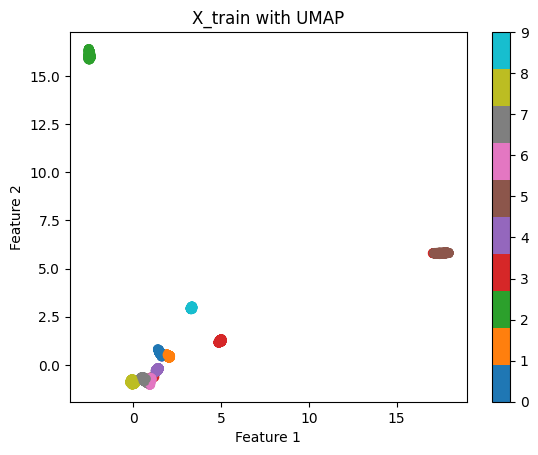

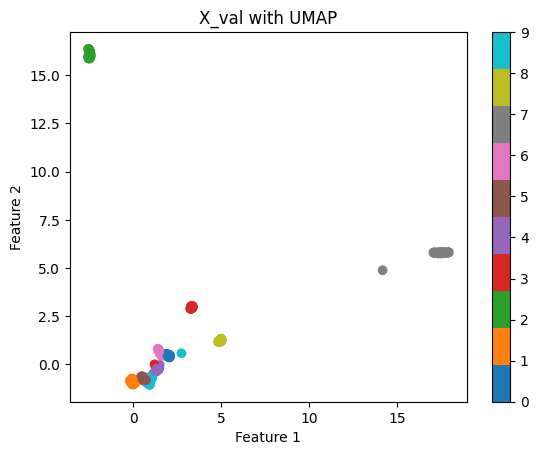

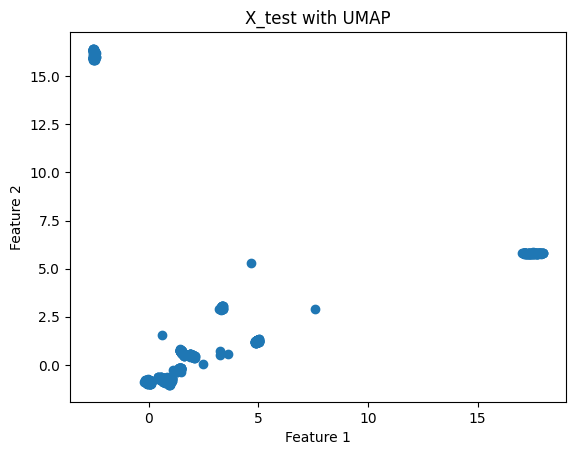

In [18]:
print(f"Number of features: {X_train_umap.shape[1]}")

silhouette_train = silhouette_score(X_train_umap, train_numeric_labels)
silhouette_val = silhouette_score(X_val_umap, val_numeric_labels)

print(f"Silhouette Score for Training Data: {silhouette_train}")
print(f"Silhouette Score for Validation Data: {silhouette_val}")

# Plot for X_train
fig = plt.figure()
numeric_labels, _ = pd.factorize(Y_train[0])
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=numeric_labels, cmap='tab10')
plt.title("X_train with UMAP")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.show()


# Plot for X_val
fig = plt.figure()
numeric_labels, _ = pd.factorize(Y_val[0])
plt.scatter(X_val_umap[:, 0], X_val_umap[:, 1], c=numeric_labels, cmap='tab10')
plt.title("X_val with UMAP")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.show()

# Plot for X_test
fig = plt.figure()
numeric_labels, _ = pd.factorize(Y_val[0])
plt.scatter(X_test_umap[:, 0], X_test_umap[:, 1])
plt.title("X_test with UMAP")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

## Implementación

La implementación de los Modelos de Clustering a usar

### HyperparameterSearch

Esta clase `Experimentacion_modelo` se implemento para automatizar la experimentación con modelos definidos y implementados:

1. **Inicialización**: Se inicializa con el modelo a evaluar, un diccionario de hiperparámetros para luego poder usar las combinaciones de ellos, conjuntos de datos de entrenamiento (`x_train`, `y_train`), y opcionalmente conjuntos de validación (`x_val`, `y_val`) y prueba (`x_test`).

2. **Configuración de Hiperparámetros**: `set_combinaciones` genera todas las combinaciones posibles de hiperparámetros especificados en `hiperparametros`.

3. **Entrenamiento y Evaluación**: `experimentacion` itera sobre todas las combinaciones de hiperparámetros, entrena el modelo con `train` (o `train` y `predict` para DBSCAN), evalúa con `val` y `test`, y calcula métricas de rendimiento como el índice de silueta, Rand ajustado y la información mutua ajustada.

4. **Eliminación de Ruido**: `remove_noise` y `remove_noise_b` eliminan los puntos etiquetados como ruido (`NOISE`) del conjunto de datos según los resultados del clustering.

5. **Métricas de Evaluación**: `get_metrics` calcula las métricas de evaluación para conjuntos de datos etiquetados (`x_train` y `x_val`) y no etiquetados (`x_test`), especificamente para este ultimo conjunto de datos se implemento una funcion adicional aparte ya que no se podia ni el ARI ni el AMI porque no se tienen los labels de X_test.

6. **Selección de Mejores Hiperparámetros**: `extract_best_hiper` selecciona las mejores combinaciones de hiperparámetros basadas en el promedio del índice de silueta de los conjuntos de entrenamiento, validación y prueba.

7. **Generación de Reporte**: `generater_reporte` crea un DataFrame que resume las métricas de rendimiento para cada combinación de hiperparámetros.

8. **Predicción**: `predict` permite hacer predicciones usando el modelo entrenado con los mejores hiperparámetros.

Esta clase facilita la experimentación sistemática con diferentes configuraciones de hiperparámetros y evaluación exhaustiva, permite comparar y seleccionar los mejores hiperparámetros según diversas métricas de rendimiento y asi luego poder comparar mejor los modelos.

In [19]:
# import metrics to evaluate clustering models
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score

NOISE = -1
UNDEFINED = -2

import itertools

class Experimentacion_modelo:
    ## Atributes
    def __init__(self, model, hiper_parms, x_train, y_train, x_val = None, y_val = None, x_test=None, name_model = ""):
        self.model = model
        self.hiperparametros = hiper_parms  # Diccionario de hiperparametros
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.x_test = x_test
        self.name_model = name_model
        # # self.y_test = y_test
        # self.k_fold = KFold(n_splits=k_fold, shuffle=True, random_state=42)

        # atributos para guardar resultados
        self.resultados = {}
        self.combinaciones_hiper = None  # Guardar combinaciones de hiperparametros

        # best hiperparametros
        self.best_hiper = None

    def set_combinaciones(self):
        combinaciones_hiper = []
        for tupla in itertools.product(*self.hiperparametros.values()):
            tipos_originales = [type(valor) for valor in self.hiperparametros.values()]
            nueva_tupla = [valor if isinstance(tipo, type) else [valor] for tipo, valor in zip(tipos_originales, tupla)]
            combinaciones_hiper.append(nueva_tupla)

        self.combinaciones_hiper = combinaciones_hiper
        return combinaciones_hiper

    ## Methods
    def experimentacion(self):
        # Generar combinaciones de hiperparametros a probar
        combinaciones_hiper = self.set_combinaciones()

        # Entrenar modelo y encontrar hiperparametros
        if self.name_model == "DBSCAN":
            for i, hiper in enumerate(combinaciones_hiper):
                result_temp = []

                # Modelo con train:
                self.model.set_params(*hiper)
                labels= self.model.train(self.x_train)

                # eliminar ruido
                X_noiseless,labels_noiseless, y_true_labels = self.remove_noise(self.x_train, labels=labels, y_true=self.y_train)
                # Guardar resultados de los scores obtenidos
                result_temp.append(self.get_metrics(X_noiseless,labels_noiseless, y_true_labels, "Train"))

                # Evaluar modelo con val:
                labels = self.model.predict(self.x_val)

                # eliminar ruido
                X_noiseless,labels_noiseless, y_true_labels = self.remove_noise(self.x_val, labels=labels, y_true=self.y_val)
                # Guardar resultados de los scores obtenidos
                result_temp.append(self.get_metrics(X_noiseless,labels_noiseless, y_true_labels, "Val"))

                # Evaluar modelo con test:
                labels = self.model.predict(self.x_test)
                # eliminar ruido
                X_noiseless,labels_noiseless = self.remove_noise_b(self.x_test, labels=labels)
                # Guardar resultados de los scores obtenidos
                result_temp.append(self.get_metrics_test(x=X_noiseless, y_labels=labels_noiseless))

                self.resultados[i]=result_temp

        else:
            for i, hiper in enumerate(combinaciones_hiper):
                result_temp = []
                # Modelo con train:
                self.model.set_params(*hiper)
                labels = self.model.train(self.x_train, self.y_train)
                # Guardar resultados de los scores obtenidos
                result_temp.append(
                    self.get_metrics(self.x_train, labels, self.y_train, "Train")
                )

                # Evaluar modelo con val:
                labels = self.model.predict(self.x_val)
                # Guardar resultados de los scores obtenidos
                result_temp.append(
                    self.get_metrics(self.x_val, labels, self.y_val, "Val")
                )

                # Evaluar modelo con test:
                labels = self.model.predict(self.x_test)
                # Guardar resultados de los scores obtenidos
                result_temp.append(
                    self.get_metrics_test(x=self.x_test, y_labels=labels)
                )

                self.resultados[i] = result_temp

        # Extraer los mejores hiperparametros
        self.best_hiper = self.extract_best_hiper()
        return {key: value for key, value in zip(self.hiperparametros.keys(), self.best_hiper[0])}

    def remove_noise(self, x, labels, y_true):
        X_noiseless = []
        labels_noiseless = []
        y_true_labels = []
        for i in range(len(x)):
            if labels[i] != NOISE:
                X_noiseless.append(x[i])
                labels_noiseless.append(labels[i])
                y_true_labels.append(y_true[i])
        return X_noiseless, labels_noiseless, y_true_labels

    def remove_noise_b(self, x, labels):
        X_noiseless = []
        labels_noiseless = []
        for i in range(len(x)):
            if labels[i] != NOISE:
                X_noiseless.append(x[i])
                labels_noiseless.append(labels[i])
        return X_noiseless, labels_noiseless

    def get_metrics(self, x , y_labels , y_true, name=""):
        # Calculate clustering metrics

        silhouette = round(silhouette_score(x, y_labels),3)
        ari = round(adjusted_rand_score(y_true, y_labels),3)
        ami = round(adjusted_mutual_info_score(y_true, y_labels),3)

        return [silhouette, ari, ami, name]

    def get_metrics_test(self, x, y_labels):
        # Calculate clustering metrics

        silhouette = round(silhouette_score(x, y_labels),3)
        ari = 0
        ami = 0

        return [silhouette, ari, ami, "Test"]

    def extract_best_hiper(self):
        # Convertir el diccionario a una lista de tuplas para trabajar con los datos
        resultados_lista = [
            (hiper, valores) for hiper, valores in self.resultados.items()
        ]
        # Ordenar los resultados basados en el promedio del índice de Silueta de "Train", "Val" y "Test"
        resultados_ordenados = sorted(
            resultados_lista,
            key=lambda x: sum(val[0] for val in x[1]) / 3,
            reverse=True,
        )

        # Extraer los índices de los 5 mejores
        mejores_indices = [indice for indice, _ in resultados_ordenados[:5]]

        # Obtener las combinaciones de hiperparámetros usando los índices extraídos
        mejores_hiper = [self.combinaciones_hiper[indice] for indice in mejores_indices]
        self.best_hiper = mejores_hiper
        return mejores_hiper

    # ploteo de resultados
    def get_matrix_similitud(self,):
        # TODO: Implementar
        pass

    def generater_reporte(self):
        # Crear el diccionario de diccionarios
        data = {}
        for combo in self.combinaciones_hiper:
            data[", ".join(map(str, combo))] = {
                "silhouette": [],
                "ari": [],
                "ami": [],
                "name": [],
            }

        # Llenar los datos
        for key, combos in self.resultados.items():
            for combo in combos:
                combo_str = ", ".join(map(str, self.combinaciones_hiper[key]))
                data[combo_str]["silhouette"].append(combo[0])
                data[combo_str]["ari"].append(combo[1])
                data[combo_str]["ami"].append(combo[2])
                data[combo_str]["name"].append(combo[3])

        # Convertir a DataFrame
        reporte = pd.DataFrame.from_dict(data, orient="index")

        return reporte

    def training_model_direct(self, hiper):
        self.model.set_params(*hiper)
        return self.model.train(self.x_train, self.y_train)

    # Entrenar modelo con los mejores hiperparametros para la predicción final
    def training_model(self, i=0, labels=None):
        if labels is not None:
            self.model.set_params(*self.best_hiper[i])
            return self.model.train(self.x_train, labels)
        else:
            self.model.set_params(*self.best_hiper[i])
            return self.model.train(self.x_train) 

    # Entrenar modelo sin tener que esperar

    def predict(self, x_test):
        y_pred = self.model.predict(x_test)
        return y_pred
    

### Modelo 1: KMeans

Este código implementa el algoritmo K-Means para clustering de datos.  Acontinuacion se muestra un resumen de su funcionamiento:

1. **Inicialización**: La clase `KMeans` permite configurar parámetros como el número de clusters (`k`) y el umbral de convergencia (`umbral`).

2. **Métodos de Distancia**: Utiliza la distancia Euclidiana para medir la proximidad entre puntos en el espacio.

3. **Inicialización de Centroides**: Inicia los centroides de los clusters aleatoriamente seleccionando `k` puntos del conjunto de datos.

4. **Asignación de Clusters**: Agrupa los puntos de datos en clusters según la distancia a los centroides actuales.

5. **Actualización de Centroides**: Calcula nuevos centroides ajustando su posición al promedio de los puntos asignados a cada cluster.

6. **Entrenamiento**: Itera hasta que la distancia promedio entre los centroides antiguos y los nuevos centroides sea menor que el umbral definido, actualizando tanto los centroides como los clusters.

7. **Predicción**: Asigna nuevos puntos de datos a los clusters existentes basándose en los centroides aprendidos durante el entrenamiento.

8. **Obtención de Centroides**: Permite obtener los centroides finales después del entrenamiento para su uso posterior.

Este algoritmo busca minimizar la varianza dentro de cada cluster y maximizar la separación entre los clusters, con el objetivo de encontrar estructuras latentes en los datos.

Para la experimentación probamos con la reducción de dimensionalidad más efectiva (UMAP)

In [20]:
import numpy as np


class KMeans:

    def __init__(self):
        self.umbral = None
        self.k = None
        self.centroides = None
        self.clusters = None

    def set_params(self, k, umbral):
        self.umbral = umbral
        self.k = k

    def distance(self, v1, v2):
        return np.linalg.norm(v1 - v2)

    def init_Centroide(self, data, k):
        np.random.seed(737)
        indices = np.random.choice(len(data), k, replace=False)
        return data[indices]

    def return_new_centroide(self, grupos, data, k):
        new_centroides = []
        for clase in range(k):
            cluster_data = data[grupos == clase]
            if len(cluster_data) > 0:
                new_centroides.append(np.mean(cluster_data, axis=0))
            else:
                new_centroides.append(data[np.random.randint(len(data))])
        return np.array(new_centroides)

    def get_cluster(self, data, centroides):
        grupos = np.zeros(len(data))
        for i in range(len(data)):
            distancias = np.zeros(len(centroides))
            for clase in range(len(centroides)):
                distancias[clase] = self.distance(data[i], centroides[clase])
            grupos[i] = np.argmin(distancias)
        return grupos

    def distancia_promedio_centroides(self, old_centroides, new_centroides):
        # Initialize array of distances
        promedios = []
        # Iterate each
        for i in range(old_centroides.shape[0]):
            # Get distance between them
            dist = self.distance(old_centroides[i], new_centroides[i])
            # Append to mean
            promedios.append(dist)
        # Return mean value
        return np.mean(promedios)

    def train(self, data, labels=None):
        centroides = self.init_Centroide(data, self.k)
        clusters = self.get_cluster(data, centroides)
        new_centroides = self.return_new_centroide(clusters, data, self.k)
        while self.distancia_promedio_centroides(centroides, new_centroides) > self.umbral:
            centroides = new_centroides
            clusters = self.get_cluster(data, centroides)
            new_centroides = self.return_new_centroide(clusters, data, self.k)
        self.centroides = new_centroides
        self.clusters = clusters
        return clusters

    def predict(self, data):
        clusters = self.get_cluster(data, self.centroides)
        return clusters
    
    def fetch_centroides(self):
        return self.centroides

In [21]:
# Experimentacion
model_kmb = KMeans()
# params to k means mejorado  k, umbral)
kmb_hyperparam = {
    "k": [10],
    "umbral": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
}

# (self, model, hiper_parms, x_train, y_train, x_val = None, y_val = None, x_test=None, name_model = ""):
experiment_kmb = Experimentacion_modelo(model_kmb, kmb_hyperparam, X_train_umap, Y_train[0], X_val_umap, Y_val[0], X_test_umap, "KM_MEJORADO")

In [22]:
start_time = time.time()
best_hiper_kmb = experiment_kmb.experimentacion()
end_time = time.time()
print("Mejores hiperparametros para K means: \n", best_hiper_kmb)

exp_duration_kmb = end_time - start_time
print("Duración del exerimentación:", exp_duration_kmb, "segundos")

Mejores hiperparametros para K means: 
 {'k': 10, 'umbral': 1e-06}
Duración del exerimentación: 19.986852884292603 segundos


In [23]:
print("Top 5   [k, umbral]")
for i, hiper in enumerate(experiment_kmb.best_hiper):
    print(f"Hiperparametros {i+1}: ", hiper)
print()

reporte2 = experiment_kmb.generater_reporte()
reporte2.head(10)

Top 5   [k, umbral]
Hiperparametros 1:  [10, 1e-06]
Hiperparametros 2:  [10, 1e-05]
Hiperparametros 3:  [10, 0.0001]
Hiperparametros 4:  [10, 0.001]
Hiperparametros 5:  [10, 0.01]



,silhouette,ari,ami,name
"10, 1e-06","[0.444, 0.418, 0.407]","[0.423, 0.42, 0]","[0.749, 0.734, 0]","[Train, Val, Test]"
"10, 1e-05","[0.444, 0.418, 0.407]","[0.423, 0.42, 0]","[0.749, 0.734, 0]","[Train, Val, Test]"
"10, 0.0001","[0.444, 0.418, 0.407]","[0.423, 0.42, 0]","[0.749, 0.734, 0]","[Train, Val, Test]"
"10, 0.001","[0.444, 0.418, 0.407]","[0.423, 0.42, 0]","[0.749, 0.734, 0]","[Train, Val, Test]"
"10, 0.01","[0.444, 0.418, 0.407]","[0.423, 0.42, 0]","[0.749, 0.734, 0]","[Train, Val, Test]"
"10, 0.1","[0.443, 0.418, 0.406]","[0.423, 0.42, 0]","[0.749, 0.734, 0]","[Train, Val, Test]"
"10, 1","[0.432, 0.415, 0.405]","[0.424, 0.42, 0]","[0.75, 0.734, 0]","[Train, Val, Test]"


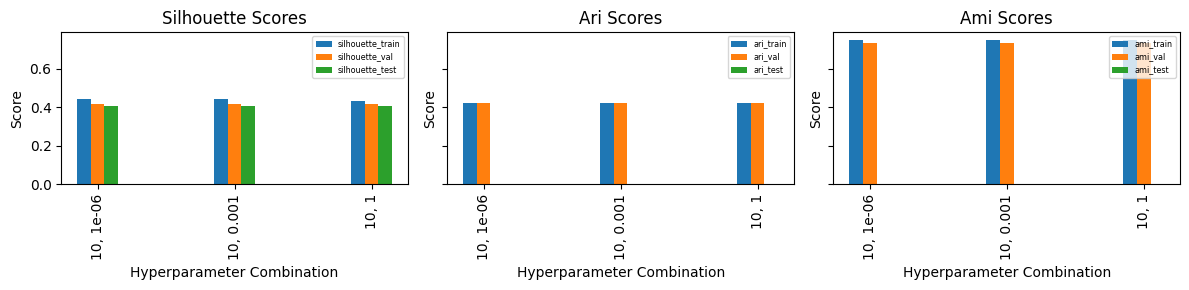

In [31]:
metrics = ["silhouette", "ari", "ami"]
k = 5  #
plot_metrics_grid(reporte2, metrics, k)


In [32]:
kmeans_train_labels = experiment_kmb.training_model(i=0, labels=Y_train[0])  # 0 porque es el top 1 en de un top 5 de best hiperparams
kmeans_val_labels = experiment_kmb.predict(X_val_umap)
kmeans_test_labels = experiment_kmb.predict(X_test_umap)
centroides_train = experiment_kmb.model.fetch_centroides()

kmeans_train_labels2 = experiment_kmb.training_model(i=1, labels=Y_train[0])
kmeans_test_labels2 = experiment_kmb.predict(X_test_umap)

print(np.unique(kmeans_test_labels, return_counts=True))

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([153,  78,  52, 327,  55,  25,  22,  26,  34,  32]))


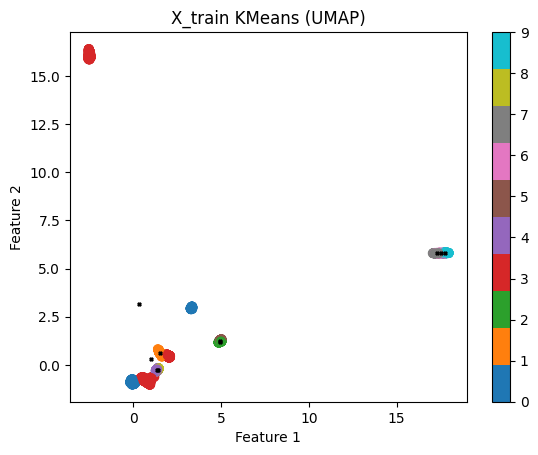

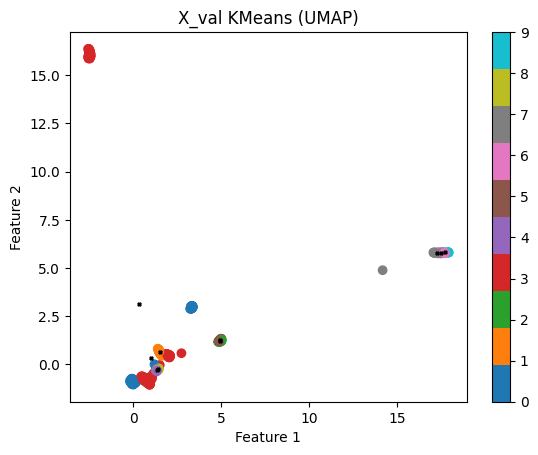

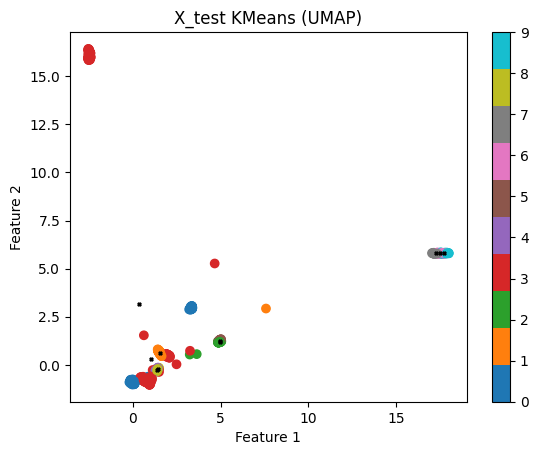

In [33]:
# Plot for X_train
fig = plt.figure()
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=kmeans_train_labels, cmap='tab10')
plt.title("X_train KMeans (UMAP)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.scatter(centroides_train[:, 0], centroides_train[:, 1], c='black', marker='X', s=5)
plt.show()


# Plot for X_val
fig = plt.figure()
plt.scatter(X_val_umap[:, 0], X_val_umap[:, 1], c=kmeans_val_labels, cmap='tab10')
plt.title("X_val KMeans (UMAP)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.scatter(centroides_train[:, 0], centroides_train[:, 1], c='black', marker='X', s=5)
plt.show()

# Plot for X_val
fig = plt.figure()
plt.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=kmeans_test_labels, cmap='tab10')
plt.title("X_test KMeans (UMAP)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.scatter(centroides_train[:, 0], centroides_train[:, 1], c='black', marker='X', s=5)
plt.show()

### Modelo 2: KMeans Mejorado

Este código implementa una versión mejorada del algoritmo K-Means, llamado `KMeansMejorado`, que incluye algunas mejoras con respecto a la implementación estándar. A continuacion se muestra un  resumen de su funcionamiento:

1. **Inicialización**: La clase `KMeansMejorado` permite configurar parámetros como el número de clusters (`k`) y el umbral de convergencia (`umbral`).

2. **Inicialización de Centroides Mejorada**: `init_centroide_mejorado` utiliza un punto por true label conocido para incializar los centroides cerca a sus ubicaciones reales. Se necesita al menos conocer un punto por label.

3. **Entrenamiento**: Itera hasta que la distancia promedio entre los centroides antiguos y los nuevos centroides sea menor que el umbral definido. Durante cada iteración, actualiza tanto los centroides como los clusters.

4. **Obtención de Datos de Clusters y Centroides**: `fetch_cluster_data` y `fetch_centroides` permiten obtener los centroides finales y los clusters después del entrenamiento para su uso posterior.

5. **Método de Distancia**: Utiliza la distancia Euclidiana para medir la proximidad entre puntos en el espacio.

6. **Actualización de Centroides**: `return_new_centroide` calcula nuevos centroides ajustando su posición al promedio de los puntos asignados a cada cluster.

7. **Asignación de Clusters**: `get_cluster` agrupa los puntos de datos en clusters según la distancia a los centroides actuales.

8. **Predicción**: Asigna nuevos puntos de datos a los clusters existentes basándose en los centroides aprendidos durante el entrenamiento.

Esta versión mejorada busca una mejor convergencia inicial de los centroides y, potencialmente, una mejor solución global en comparación con el K-Means estándar.

Para la experimentación probamos con la reducción de dimensionalidad más efectiva (UMAP)

In [34]:
class KMeansMejorado:
    def __init__(self):
        self.umbral = None
        self.k = None
        self.centroides = None
        self.clusters = None

    def set_params(self, k, umbral):
        self.umbral = umbral
        self.k = k

    def train(self, data, labels):
        self.centroides = self.init_centroide_mejorado(data, labels)
        self.clusters = self.get_cluster(data)
        new_centroides = self.return_new_centroide(data)
        while self.distancia_promedio_centroides(new_centroides) > self.umbral:
            self.centroides = new_centroides
            self.clusters = self.get_cluster(data)
            new_centroides = self.return_new_centroide(data)

        return self.clusters

    def fetch_cluster_data(self):
        return self.centroides, self.clusters

    def fetch_centroides(self):
        return self.centroides

    def distance(self, v1, v2):
        return np.linalg.norm(v1-v2)

    def init_centroide_mejorado(self, data, labels):
        centroides = []
        clases = []
        i = 0
        while len(centroides) < self.k:
            if not labels[i] in clases:
                clases.append(labels[i])
                centroides.append(data[i])
            i += 1
        return np.array(centroides)

    def return_new_centroide(self, data):
        new_centroides = []
        for clase in range(self.k):
            cluster_data = data[self.clusters == clase]
            if len(cluster_data) > 0:
                new_centroides.append(np.mean(cluster_data, axis=0))
            else:
                new_centroides.append(data[np.random.randint(len(data))])
        return np.array(new_centroides)

    def get_cluster(self, data):
        grupos = np.zeros(len(data))
        for i in range(len(data)):
            distancias = np.zeros(len(self.centroides))
            for clase in range(len(self.centroides)):
                distancias[clase] = self.distance(data[i], self.centroides[clase])
            grupos[i] = np.argmin(distancias)
        return grupos

    def distancia_promedio_centroides(self, new_centroides):
        # Initialize array of distances
        promedios = []
        # Iterate each
        for i in range(self.centroides.shape[0]):
            # Get distance between them
            dist = self.distance(self.centroides[i], new_centroides[i])
            # Append to mean
            promedios.append(dist)
        # Return mean value
        return np.mean(promedios)

    def predict(self, data):
        clusters = self.get_cluster(data)
        return clusters

Ejecución Experimentacion del Modelo KMeans Mejorado:

In [35]:
# Experimentacion
model_kmm = KMeansMejorado()
# params to k means mejorado  k, umbral)
kmm_hyperparam = {
    "k": [10],
    "umbral": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
}

# (self, model, hiper_parms, x_train, y_train, x_val = None, y_val = None, x_test=None, name_model = ""):
experiment_kmm = Experimentacion_modelo(model_kmm, kmm_hyperparam, X_train_umap, Y_train[0], X_val_umap, Y_val[0], X_test_umap, "KM_MEJORADO")

In [36]:
start_time = time.time()
best_hiper_kmm = experiment_kmm.experimentacion()
end_time = time.time()
print("Mejores hiperparametros para K means mejorado: \n", best_hiper_kmm)

exp_duration_kmm = end_time - start_time
print("Duración del exerimentación:", exp_duration_kmm, "segundos")

Mejores hiperparametros para K means mejorado: 
 {'k': 10, 'umbral': 1e-06}
Duración del exerimentación: 16.598599672317505 segundos


In [37]:
print("Top 5   [k, umbral]")
for i, hiper in enumerate(experiment_kmm.best_hiper):
    print(f"Hiperparametros {i+1}: ", hiper)
print()

reporte1 = experiment_kmm.generater_reporte()
reporte1.head(10)

Top 5   [k, umbral]
Hiperparametros 1:  [10, 1e-06]
Hiperparametros 2:  [10, 1e-05]
Hiperparametros 3:  [10, 0.0001]
Hiperparametros 4:  [10, 0.001]
Hiperparametros 5:  [10, 0.01]



,silhouette,ari,ami,name
"10, 1e-06","[0.881, 0.854, 0.865]","[0.949, 0.91, 0]","[0.951, 0.927, 0]","[Train, Val, Test]"
"10, 1e-05","[0.881, 0.854, 0.865]","[0.949, 0.91, 0]","[0.951, 0.927, 0]","[Train, Val, Test]"
"10, 0.0001","[0.881, 0.854, 0.865]","[0.949, 0.91, 0]","[0.951, 0.927, 0]","[Train, Val, Test]"
"10, 0.001","[0.881, 0.854, 0.865]","[0.948, 0.91, 0]","[0.951, 0.927, 0]","[Train, Val, Test]"
"10, 0.01","[0.88, 0.853, 0.865]","[0.949, 0.906, 0]","[0.951, 0.925, 0]","[Train, Val, Test]"
"10, 0.1","[0.862, 0.836, 0.855]","[0.906, 0.891, 0]","[0.939, 0.921, 0]","[Train, Val, Test]"
"10, 1","[0.836, 0.818, 0.834]","[0.87, 0.874, 0]","[0.93, 0.918, 0]","[Train, Val, Test]"


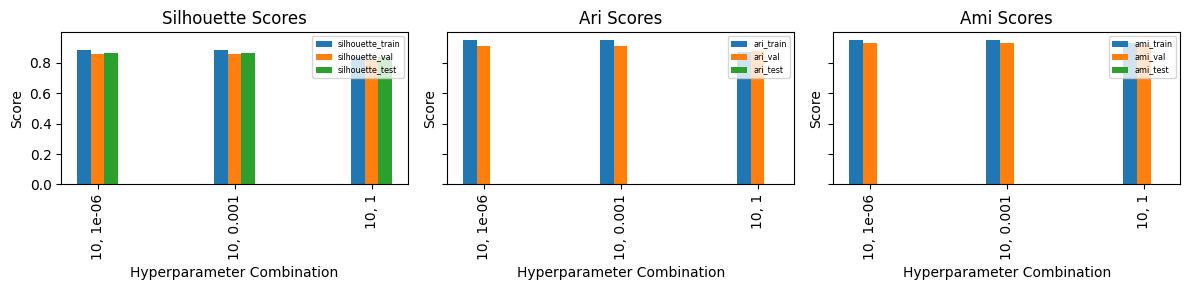

In [38]:
metrics = ['silhouette', 'ari', 'ami']
k = 5  #
plot_metrics_grid(reporte1, metrics, k)

In [39]:
kmeans_m_train_labels = experiment_kmm.training_model(i=0, labels=Y_train[0])  # 0 porque es el top 1 en de un top 5 de best hiperparams
kmeans_m_val_labels = experiment_kmm.predict(X_val_umap)
kmeans_m_test_labels = experiment_kmm.predict(X_test_umap)
centroides_m_train = experiment_kmm.model.fetch_centroides()

kmeans_m_train_labels2 = experiment_kmm.training_model(i=1, labels=Y_train[0])
kmeans_m_test_labels2 = experiment_kmm.predict(X_test_umap)

print(np.unique(kmeans_m_test_labels, return_counts=True))

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([78, 79, 84, 77, 90, 80, 88, 74, 74, 80]))


Gráficas y métricas para KMeans usando UMAP:

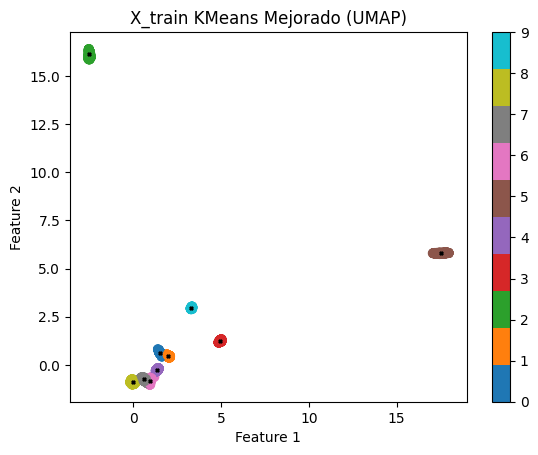

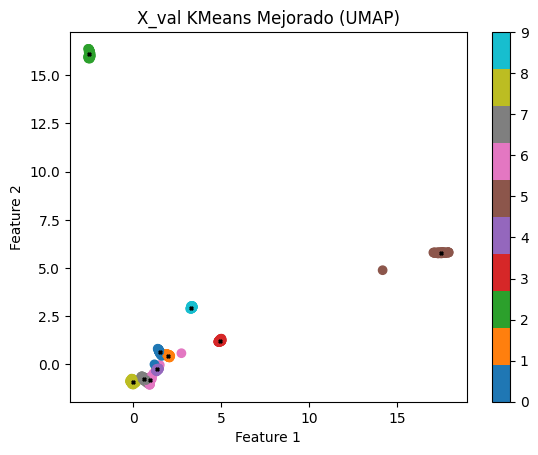

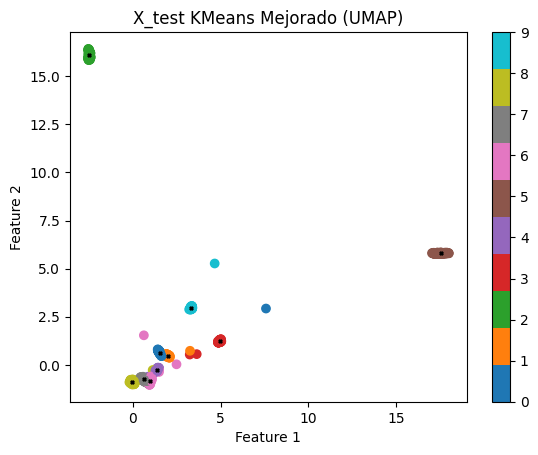

In [40]:
# Plot for X_train
fig = plt.figure()
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=kmeans_m_train_labels, cmap='tab10')
plt.title("X_train KMeans Mejorado (UMAP)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.scatter(centroides_m_train[:, 0], centroides_m_train[:, 1], c='black', marker='X', s=5)
plt.show()


# Plot for X_val
fig = plt.figure()
plt.scatter(X_val_umap[:, 0], X_val_umap[:, 1], c=kmeans_m_val_labels, cmap='tab10')
plt.title("X_val KMeans Mejorado (UMAP)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.scatter(centroides_m_train[:, 0], centroides_m_train[:, 1], c='black', marker='X', s=5)
plt.show()

# Plot for X_val
fig = plt.figure()
plt.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=kmeans_m_test_labels, cmap='tab10')
plt.title("X_test KMeans Mejorado (UMAP)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.scatter(centroides_m_train[:, 0], centroides_m_train[:, 1], c='black', marker='X', s=5)
plt.show()

### Modelo 3: DBSCAN

El modelo DBSCAN es un algoritmo de clustering basado en densidad que es capaz de identificar clusters de forma arbitraria y detectar puntos ruido, en este sentido a continuacion la implementacion de este modelo.

1. **Inicialización**: La clase `DBSCAN` tiene métodos para configurar parámetros (`radio` y `vecinos_min`), entrenar el modelo con un conjunto de datos (`train`) y predecir etiquetas para nuevos puntos (`predict`).

2. **Parámetros**: `set_params` configura el radio de búsqueda y el número mínimo de vecinos necesarios para formar un grupo.

3. **Entrenamiento**: 
   - Construye un `KDTree` para buscar vecinos eficientemente.
   - Asigna puntos a clusters basándose en la densidad de vecinos dentro del radio especificado.
   - Etiqueta puntos como `NOISE` (ruido) si no tienen suficientes vecinos.

4. **Predicción**:
   - Para nuevos puntos, busca sus vecinos.
   - Etiqueta los puntos nuevos según el cluster más común de sus vecinos o como `NOISE` si no tienen vecinos suficientes.

In [41]:
from sklearn.neighbors import KDTree
from collections import Counter

class DBSCAN():
    def __init__(self):
        self.radio = None
        self.vecinos_min = None
        self.tree = None
        self.clusters = None

    def set_params( self, radio, vecinos_min):
        self.radio = radio
        self.vecinos_min = vecinos_min

    def train(self, ds):
        tree = KDTree(ds)
        n, k = ds.shape
        marked_count = 0
        cluster = [UNDEFINED for _ in range(n)]
        cluster_count = -1

        stack = [0]
        while True:
            if len(stack) == 0:
                try:
                    stack.append(cluster.index(UNDEFINED))
                except:
                    self.tree = tree
                    self.cluster = cluster
                    return cluster
            current_index = stack.pop()

            # sin marcar -> crear nuevo cluster
            if cluster[current_index] == UNDEFINED:  # if unmarked
                marked_count += 1
                neighbors = tree.query_radius([ds[current_index]], self.radio)[0]
                n_neighbors = len(neighbors)
                if n_neighbors < self.vecinos_min:  # ruido
                    cluster[current_index] = NOISE
                else:  # caso normal
                    cluster_count += 1
                    cluster[current_index] = cluster_count
                    for v in neighbors:
                        stack.append(v)
                        cluster[v] = cluster_count
            # marcado
            else:
                neighbors = tree.query_radius([ds[current_index]], self.radio)[0]
                for v in neighbors:
                    if cluster[v] == UNDEFINED:
                        marked_count += 1
                        stack.append(v)
                        cluster[v] = cluster_count
                    if cluster[v] == NOISE:
                        cluster[v] = cluster_count
        self.tree = tree
        self.cluster = cluster
        return cluster

    def predict(self, new_points):
        predicted_labels = []
        for point in new_points:
            neighbors = self.tree.query_radius([point], self.radio)[0]
            if len(neighbors) == 0:
                predicted_labels.append(NOISE)
            else:
                neighbor_clusters = [
                    self.cluster[neighbor]
                    for neighbor in neighbors
                    if self.cluster[neighbor] != NOISE
                ]
                if len(neighbor_clusters) == 0:
                    predicted_labels.append(NOISE)
                else:
                    most_common_cluster = Counter(neighbor_clusters).most_common(1)[0][0]
                    predicted_labels.append(most_common_cluster)
        return predicted_labels

In [50]:
# Experimentacion
model_dbscan = DBSCAN()
# params to dbscan  radio, vecinos_min)
db_hyperparam = {
    "radio": [0.15, 0.3, 0.5, 1.0, 2.0, 5.0],
    "vecinos_min": [5, 10, 15, 20],
}

# (self, model, hiper_parms, x_train, y_train, x_val = None, y_val = None, x_test=None, name_model = ""):
experiment_db = Experimentacion_modelo(model_dbscan, db_hyperparam, X_train_umap, Y_train[0], X_val_umap, Y_val[0], X_test_umap, "DBSCAN")

In [51]:
start_time = time.time()
best_hiper_db = experiment_db.experimentacion()
end_time = time.time()
print("Mejores hiperparametros para DBSCAN: \n", best_hiper_db)

exp_duration_db = end_time - start_time
print("Duración del exerimentación:", exp_duration_db, "segundos")

Mejores hiperparametros para DBSCAN: 
 {'radio': 0.3, 'vecinos_min': 5}
Duración del exerimentación: 67.31688833236694 segundos


In [53]:
print("Top 5   [Radio, vecinos_min]")
for i, hiper in enumerate(experiment_db.best_hiper):
    print(f"Hiperparametros {i+1}: ", hiper)


reporte = experiment_db.generater_reporte()
reporte

Top 5   [Radio, vecinos_min]
Hiperparametros 1:  [0.3, 5]
Hiperparametros 2:  [0.3, 10]
Hiperparametros 3:  [0.3, 15]
Hiperparametros 4:  [0.3, 20]
Hiperparametros 5:  [0.5, 5]


,silhouette,ari,ami,name
"0.15, 5","[0.598, 0.807, 0.623]","[0.933, 0.92, 0]","[0.933, 0.938, 0]","[Train, Val, Test]"
"0.15, 10","[0.823, 0.807, 0.813]","[0.94, 0.92, 0]","[0.941, 0.938, 0]","[Train, Val, Test]"
"0.15, 15","[0.833, 0.815, 0.816]","[0.955, 0.93, 0]","[0.952, 0.949, 0]","[Train, Val, Test]"
"0.15, 20","[0.894, 0.862, 0.863]","[0.968, 0.935, 0]","[0.962, 0.953, 0]","[Train, Val, Test]"
"0.3, 5","[0.954, 0.95, 0.95]","[0.868, 0.877, 0]","[0.94, 0.945, 0]","[Train, Val, Test]"
"0.3, 10","[0.954, 0.95, 0.95]","[0.868, 0.877, 0]","[0.94, 0.945, 0]","[Train, Val, Test]"
"0.3, 15","[0.954, 0.95, 0.95]","[0.868, 0.877, 0]","[0.94, 0.945, 0]","[Train, Val, Test]"
"0.3, 20","[0.954, 0.95, 0.95]","[0.868, 0.877, 0]","[0.94, 0.945, 0]","[Train, Val, Test]"
"0.5, 5","[0.954, 0.95, 0.95]","[0.868, 0.877, 0]","[0.94, 0.945, 0]","[Train, Val, Test]"
"0.5, 10","[0.954, 0.95, 0.95]","[0.868, 0.877, 0]","[0.94, 0.945, 0]","[Train, Val, Test]"


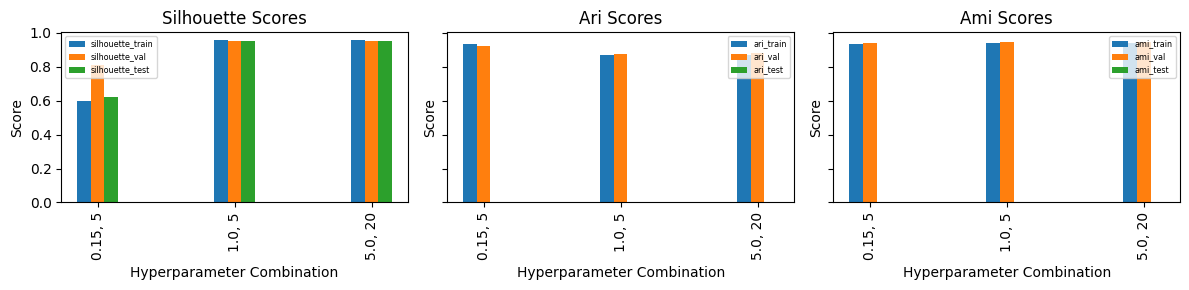

In [54]:
metrics = ['silhouette', 'ari', 'ami']
k = 5  #
plot_metrics_grid(reporte, metrics, k)


In [55]:
y_train_labels = experiment_db.training_model(i=0)  # 0 porque es el top 1 en de un top 5 de best hiperparams
y_val_labels = experiment_db.predict(X_val_umap)
y_test_labels = experiment_db.predict(X_test_umap)

y_train_labels = experiment_db.training_model(i=1)
y_test_labels2 = experiment_db.predict(X_test_umap)

print(np.unique(y_test_labels, return_counts=True))

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8]), array([ 14,  76,  78,  84,  75,  89,  80, 157,  72,  79]))


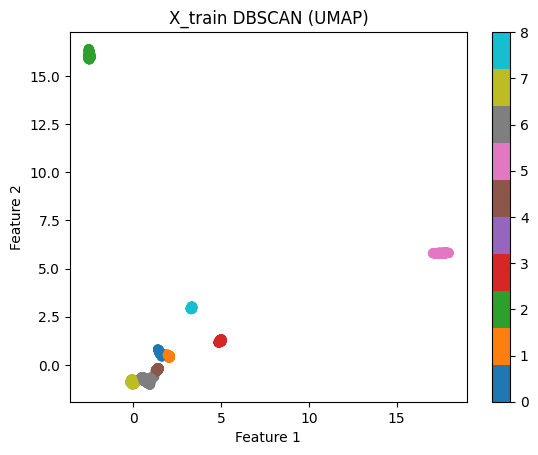

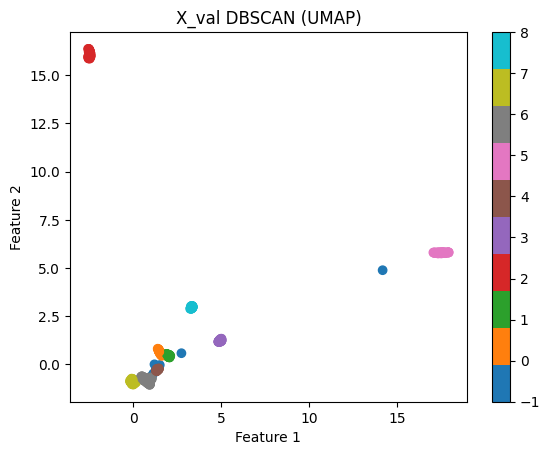

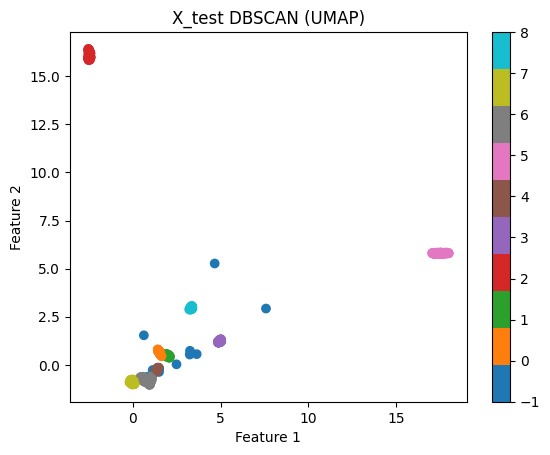

In [56]:
# Plot for X_train
fig = plt.figure()
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train_labels, cmap='tab10')
plt.title("X_train DBSCAN (UMAP)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.show()


# Plot for X_val
fig = plt.figure()
plt.scatter(X_val_umap[:, 0], X_val_umap[:, 1], c=y_val_labels, cmap='tab10')
plt.title("X_val DBSCAN (UMAP)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.show()

# Plot for X_val
fig = plt.figure()
plt.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=y_test_labels, cmap='tab10')
plt.title("X_test DBSCAN (UMAP)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.show()

## Submission

Archivo .csv para la competencia de Kaggle: https://www.kaggle.com/competitions/project-3-clustering

In [59]:
to_csv_labels(kmeans_test_labels, "submission_kmb_umap_ig65m_1.csv", test_ids, test_df)
to_csv_labels(kmeans_test_labels2, "submission_kmb_umap_ig65m_2.csv", test_ids, test_df)

to_csv_labels(kmeans_m_test_labels, "submission_kmm_umap_ig65m_1.csv", test_ids, test_df)
to_csv_labels(kmeans_m_test_labels2, "submission_kmm_umap_ig65m_2.csv", test_ids, test_df)

to_csv_labels(y_test_labels, "submission_dbscan_umap_ig65m_1.csv", test_ids, test_df)
to_csv_labels(y_test_labels2, "submission_dbscan_umap_ig65m_2.csv", test_ids, test_df)

804
805
CSV con predicciones guardado en: submission_kmb_umap_ig65m_1.csv
804
805
CSV con predicciones guardado en: submission_kmb_umap_ig65m_2.csv
804
805
CSV con predicciones guardado en: submission_kmm_umap_ig65m_1.csv
804
805
CSV con predicciones guardado en: submission_kmm_umap_ig65m_2.csv
804
805
CSV con predicciones guardado en: submission_dbscan_umap_ig65m_1.csv
804
805
CSV con predicciones guardado en: submission_dbscan_umap_ig65m_2.csv
